In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
engin = pd.read_csv("nonsparsetheta.csv")
engin = engin.drop('Unnamed: 0', axis=1)
engin['y'] = np.where(engin['target'] == engin['player1_name'],
                              'player1',
                              'player2')
m = {"player1": 0, "player2": 1}
engin['maptarget'] = engin['y'].map(m)
engin = engin.drop('y', axis=1)

In [5]:
engin.columns
enginx = engin[[
    "player1_age", 
    "player2_age", 
    "player1_ht", 
    "player2_ht", 
    "player1_rank", 
    "player2_rank", 
    "player1_h2h", 
    "player2_h2h",
    "surface", 
    "tourney_level",
    "player_1_recent_form",
    "player_2_recent_form",
    "player_1_theta_form",
    "player_2_theta_form",
    'player1_surface_win_pct', 
    'player2_surface_win_pct',
    'player1_level_win_pct', 
    'player2_level_win_pct',]]
enginy = engin['maptarget']

In [7]:
le = LabelEncoder()
enginx['surface'] = le.fit_transform(enginx['surface'])
enginx['tourney_level'] = le.fit_transform(enginx['tourney_level'])

/var/folders/f8/n3c9f3d91gl0y1xv3gycqn8c0000gn/T/ipykernel_136/2338595702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enginx['surface'] = le.fit_transform(enginx['surface'])
/var/folders/f8/n3c9f3d91gl0y1xv3gycqn8c0000gn/T/ipykernel_136/2338595702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enginx['tourney_level'] = le.fit_transform(enginx['tourney_level'])


In [8]:
engintrainx, engintestx, engintrainy, engintesty = train_test_split(enginx, enginy, test_size=0.25, random_state=5323)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

In [10]:
def cv(model, X, y, cv=100):
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(estimator=model,
                             X = X,
                             y = y,
                             cv=cv,
                             scoring=scoring,
                             return_train_score=True,
                             return_estimator=True)
    return {
            "Mean Training Accuracy": results['train_accuracy'].mean()*100,
            "Mean Training Precision": results['train_precision'].mean(),
            "Mean Training Recall": results['train_recall'].mean(),
            "Mean Training F1 Score": results['train_f1'].mean(),
            "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
            "Mean Validation Precision": results['test_precision'].mean(),
            "Mean Validation Recall": results['test_recall'].mean(),
            "Mean Validation F1 Score": results['test_f1'].mean(),
            "model": results
            }

In [11]:
logit = LogisticRegression(solver='liblinear')
logit_result = cv(logit, X=engintrainx, y = engintrainy, cv=5)

In [ ]:
logit_result

In [13]:
rf = RandomForestClassifier()

#randomized grid search cv to find the best range 
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [False]

randomgrid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = randomgrid, n_iter = 2, cv = 3, verbose=2, random_state=5323)
rf_random.fit(engintrainx, engintrainy)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  15.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  15.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  15.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  25.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  26.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  26.3s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=2,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=5323, verbose=2)

In [14]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [15]:
rft = RandomForestClassifier(n_estimators=600,
min_samples_split=4,
min_samples_leaf=4,
max_features='sqrt',
max_depth=20,
bootstrap=False)

#rfresults = cv(model = rft, X=engintrainx, y=engintrainy, cv=10)
rft.fit(engintrainx, engintrainy)

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=4,
                       min_samples_split=4, n_estimators=600)

In [17]:
from sklearn.metrics import accuracy_score
preds = rft.predict(engintestx)
accuracy_score(engintesty, preds)

0.7145187601957586

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'player1_age'),
  Text(1, 0, 'player2_age'),
  Text(2, 0, 'player1_ht'),
  Text(3, 0, 'player2_ht'),
  Text(4, 0, 'player1_rank'),
  Text(5, 0, 'player2_rank'),
  Text(6, 0, 'player1_h2h'),
  Text(7, 0, 'player2_h2h'),
  Text(8, 0, 'surface'),
  Text(9, 0, 'tourney_level'),
  Text(10, 0, 'player_1_recent_form'),
  Text(11, 0, 'player_2_recent_form'),
  Text(12, 0, 'player_1_theta_form'),
  Text(13, 0, 'player_2_theta_form'),
  Text(14, 0, 'player1_surface_win_pct'),
  Text(15, 0, 'player2_surface_win_pct'),
  Text(16, 0, 'player1_level_win_pct'),
  Text(17, 0, 'player2_level_win_pct')])

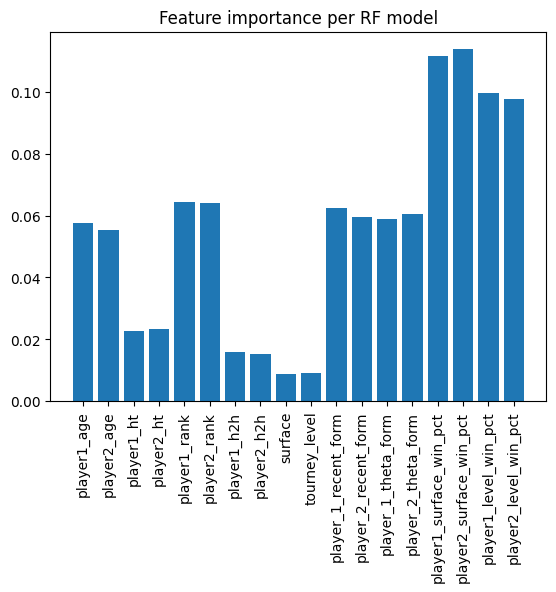

In [18]:
import matplotlib.pyplot as plt
plt.bar(engintrainx.columns, rft.feature_importances_)
plt.title("Feature importance per RF model")
plt.xticks(rotation=90)

In [52]:
xgb = xgboost.XGBClassifier()

In [53]:
xgb.fit(engintrainx, engintrainy)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [54]:
xgp = xgb.predict(engintestx)
accuracy_score(engintesty, xgp)

0.7058183795541055

In [57]:
xgresults = cv(model=xgb, X = engintrainx, y = engintrainy, cv=10)

In [58]:
xgresults

{'Mean Training Accuracy': 87.50192855538357,
 'Mean Training Precision': 0.8764518335586476,
 'Mean Training Recall': 0.8618470839953345,
 'Mean Training F1 Score': 0.8690761737191626,
 'Mean Validation Accuracy': 69.81447669921333,
 'Mean Validation Precision': 0.6923276307544588,
 'Mean Validation Recall': 0.6712663064380875,
 'Mean Validation F1 Score': 0.681597650664727,
 'model': {'fit_time': array([0.97175598, 1.08520031, 0.93712306, 0.83781505, 0.84688687,
         0.86784101, 0.85187197, 0.87049699, 0.83535004, 0.85668683]),
  'score_time': array([0.00398207, 0.00464773, 0.00352001, 0.00353384, 0.00537133,
         0.00438094, 0.00380015, 0.00439072, 0.00631499, 0.0057683 ]),
  'estimator': [XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                 colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
  

#### Exploring the confidence metric using logistic regression. Is it needed or does rank cover it well enough?

In [26]:
enginxwithout = engin[[
    "player1_age", 
    "player2_age", 
    "player1_ht", 
    "player2_ht", 
    "player1_rank", 
    "player2_rank", 
    "player1_h2h", 
    "player2_h2h",
    "surface", 
    "tourney_level",
    'player1_surface_win_pct', 
    'player2_surface_win_pct',
    'player1_level_win_pct', 
    'player2_level_win_pct',]]

enginxwith = engin[[
    "player1_age", 
    "player2_age", 
    "player1_ht", 
    "player2_ht", 
    "player1_rank", 
    "player2_rank", 
    "player1_h2h", 
    "player2_h2h",
    "surface", 
    "tourney_level",
    "player_1_theta_form",
    "player_2_theta_form",
    'player1_surface_win_pct', 
    'player2_surface_win_pct',
    'player1_level_win_pct', 
    'player2_level_win_pct',]]

enginy = engin['maptarget']

enginxwith['surface'] = le.fit_transform(enginx['surface'])
enginxwith['tourney_level'] = le.fit_transform(enginx['tourney_level'])
enginxwithout['surface'] = le.fit_transform(enginx['surface'])
enginxwithout['tourney_level'] = le.fit_transform(enginx['tourney_level'])

/var/folders/f8/n3c9f3d91gl0y1xv3gycqn8c0000gn/T/ipykernel_136/3266163630.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enginxwith['surface'] = le.fit_transform(enginx['surface'])
/var/folders/f8/n3c9f3d91gl0y1xv3gycqn8c0000gn/T/ipykernel_136/3266163630.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enginxwith['tourney_level'] = le.fit_transform(enginx['tourney_level'])
/var/folders/f8/n3c9f3d91gl0y1xv3gycqn8c0000gn/T/ipykernel_136/3266163630.py:39: SettingWithCopyWarning: 
A value is trying to

In [27]:
engintrainxwith, engintestxwith, engintrainy, engintesty = train_test_split(enginxwith, enginy, test_size=0.25, random_state=5323)
engintrainxwithout, engintestxwithout, engintrainy, engintesty = train_test_split(enginxwithout, enginy, test_size=0.25, random_state=5323)

In [29]:
from statsmodels.api import Logit

logitwith = Logit(engintrainy.astype(int),engintrainxwith).fit()
logitwithout = Logit(engintrainy.astype(int),engintrainxwithout).fit()

Optimization terminated successfully.
         Current function value: 0.560295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.560925
         Iterations 6


In [34]:
predswith = logitwith.predict(engintestxwith)
predswith = list(map(round,predswith))
print(accuracy_score(engintesty, predswith))
predswithout = logitwithout.predict(engintestxwithout)
predswithout = list(map(round,predswithout))
print(accuracy_score(engintesty, predswithout))

0.7098060540148632
0.7092622802247598


In [30]:
print(logitwith.summary())

                           Logit Regression Results                           
Dep. Variable:              maptarget   No. Observations:                16551
Model:                          Logit   Df Residuals:                    16535
Method:                           MLE   Df Model:                           15
Date:                Tue, 15 Nov 2022   Pseudo R-squ.:                  0.1909
Time:                        18:18:11   Log-Likelihood:                -9273.4
converged:                       True   LL-Null:                       -11461.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
player1_age                 0.0556      0.005     10.361      0.000       0.045       0.066
player2_age                -0.0575      0.005    -10.519      0.000      -0.068      -0.047


In [31]:
print(logitwithout.summary())

                           Logit Regression Results                           
Dep. Variable:              maptarget   No. Observations:                16551
Model:                          Logit   Df Residuals:                    16537
Method:                           MLE   Df Model:                           13
Date:                Tue, 15 Nov 2022   Pseudo R-squ.:                  0.1899
Time:                        18:18:21   Log-Likelihood:                -9283.9
converged:                       True   LL-Null:                       -11461.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
player1_age                 0.0591      0.005     11.139      0.000       0.049       0.069
player2_age                -0.0573      0.005    -10.693      0.000      -0.068      -0.047
